In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from datetime import datetime
import time
import json

# 1. DIVIDING DA DATASET

In [2]:
# Load the dataset
df = pd.read_csv("dataquest_fraud_train.csv")
df.sample(4)

,transDate,creditCardNum,business,category,amount,firstName,lastName,gender,street,city,...,latitude,longitude,cityPop,job,dateOfBirth,transNum,unixTime,merchLatitude,merchLongitude,isFraud
139720,2019-10-28 23:09,5104807169438130,fraud_Medhurst PLC,shopping_net,21.47,Regina,Johnston,F,641 Steven Mall Apt. 299,Westhampton Beach,...,40.8295,-72.6473,3255,Financial trader,1978-07-08,f6a18c871671552495cff00b743a3e07,1351465760,39.923808,-72.718925,0
66470,2019-09-27 16:09,4997733566924480,"fraud_Schneider, Hayes and Nikolaus",food_dining,27.31,Stephanie,Taylor,F,598 Martin Pine Suite 365,Saint Paul,...,44.9913,-92.9487,753116,Fisheries officer,1971-08-06,dca0a39818c41e8dd11d6ddfb33f7deb,1348762163,45.543296,-92.400310,0
167525,2019-11-10 17:41,5130484058948420,"fraud_Hettinger, McCullough and Fay",home,86.10,Ronald,White,M,25713 Hamilton Grove Apt. 903,Beaverdam,...,40.8314,-83.9758,349,Museum/gallery conservator,1978-12-25,8b1a049831df8759cf40c5f908125fcd,1352569288,40.447515,-83.231297,0
621,2019-06-20 10:11,3560336828629930,"fraud_Kihn, Abernathy and Douglas",shopping_net,4.49,Christopher,White,M,13613 Hammond Ferry,Clutier,...,42.0789,-92.3763,590,"Embryologist, clinical",1953-03-30,f85156248ff3c95fdb4a56590eb6220f,1340187102,41.680770,-92.377598,0


In [3]:
# Replace empty strings with NaN
df.replace('', np.nan, inplace=True)

# Remove rows where all elements are NaN
df.dropna(how='all', inplace=True)

# Removing firstName, lastName, transNum, creditCardNum columns
df.drop(['firstName', 'lastName', 'transNum', 'creditCardNum', 'street'], axis=1, inplace=True)

# Convert transDate column to datetime format
df['transDate'] = pd.to_datetime(df['transDate'], format='%Y-%m-%d %H:%M')

# Convert transDate to Unix time and create a new unixTime column
df['unixTime'] = df['transDate'].astype('int64') // 10**9
df = df.drop(['transDate'], axis=1)

df.head()

,business,category,amount,gender,city,state,zip,latitude,longitude,cityPop,job,dateOfBirth,unixTime,merchLatitude,merchLongitude,isFraud
0,fraud_Welch Inc,misc_net,4.10,F,Eureka,IL,61530,40.7152,-89.2706,6713,Archivist,1945-08-19,1546316880,40.020043,-89.693412,0
1,fraud_Auer-West,shopping_net,2.67,M,Mallie,KY,41836,37.2692,-82.9161,798,Facilities manager,1926-06-26,1546316880,37.622362,-82.676007,0
2,fraud_Balistreri-Nader,misc_pos,22.88,F,Tomales,CA,94971,38.2427,-122.9145,337,Occupational psychologist,1954-07-05,1546316940,39.060101,-121.969417,0
3,"fraud_Boehm, Predovic and Reinger",misc_pos,9.59,M,Belmond,IA,50421,42.8511,-93.6200,3032,Community pharmacist,1964-08-08,1546316940,43.280848,-94.340312,0
4,fraud_Hudson-Ratke,grocery_pos,129.06,F,Shenandoah Junction,WV,25442,39.3716,-77.8229,1925,Systems developer,1966-02-14,1546317120,39.211630,-78.409044,0


# 2. Catgeorical Data to Numerical Data

## Encoding Catg. Data

In [4]:
# Encoding Gender
df['gender'] = df['gender'].apply(lambda x: 0 if x == 'F' else 1)

# Encoding Age
def calculate_age(birth_date_str):
    birth_date = datetime.strptime(birth_date_str, "%Y-%m-%d")
    today = datetime.now()
    age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    return age
    
df['age'] = df['dateOfBirth'].apply(calculate_age)
df = df.drop(['dateOfBirth'], axis=1)
df.head()

,business,category,amount,gender,city,state,zip,latitude,longitude,cityPop,job,unixTime,merchLatitude,merchLongitude,isFraud,age
0,fraud_Welch Inc,misc_net,4.10,0,Eureka,IL,61530,40.7152,-89.2706,6713,Archivist,1546316880,40.020043,-89.693412,0,78
1,fraud_Auer-West,shopping_net,2.67,1,Mallie,KY,41836,37.2692,-82.9161,798,Facilities manager,1546316880,37.622362,-82.676007,0,97
2,fraud_Balistreri-Nader,misc_pos,22.88,0,Tomales,CA,94971,38.2427,-122.9145,337,Occupational psychologist,1546316940,39.060101,-121.969417,0,69
3,"fraud_Boehm, Predovic and Reinger",misc_pos,9.59,1,Belmond,IA,50421,42.8511,-93.6200,3032,Community pharmacist,1546316940,43.280848,-94.340312,0,59
4,fraud_Hudson-Ratke,grocery_pos,129.06,0,Shenandoah Junction,WV,25442,39.3716,-77.8229,1925,Systems developer,1546317120,39.211630,-78.409044,0,58


# One Hot Encoding Data

In [5]:
"""
print(df.groupby('job').job.count())
print(df.groupby('state').state.count())
print(df.groupby('city').city.count())
print(df.groupby('category').category.count())
print(df.groupby('business').business.count())
"""

#df = pd.get_dummies(df, columns=['job'])
#df = pd.get_dummies(df, columns=['state'])
#df = pd.get_dummies(df, columns=['city'])
df = pd.get_dummies(df, columns=['category'])
#df = pd.get_dummies(df, columns=['business'])

df = df.drop(["job", "state", "city", "business", "zip"], axis=1)
df.sample(5)

,amount,gender,latitude,longitude,cityPop,unixTime,merchLatitude,merchLongitude,isFraud,age,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
79617,95.20,1,39.3391,-95.0999,1442,1570074120,40.159014,-94.344748,0,41,...,True,False,False,False,False,False,False,False,False,False
27778,87.91,0,42.1001,-73.3611,2121,1563564000,42.283393,-74.280522,0,50,...,False,False,True,False,False,False,False,False,False,False
8919,58.28,0,38.8856,-77.1802,116155,1562977980,38.006303,-76.979634,0,40,...,False,False,False,False,False,True,False,False,False,False
109940,211.88,0,39.6251,-82.7552,4512,1571213820,39.747043,-83.561914,0,31,...,True,False,False,False,False,False,False,False,False,False
86802,133.71,0,38.4121,-75.2811,718,1570352760,38.626253,-75.755087,0,39,...,True,False,False,False,False,False,False,False,False,False


# 3. Adding Features

## Adding distance between transactions

In [6]:
import math
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers

    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c

    return distance

# Coordinates of the two points
lat1, lon1 = 37.2692, -82.9161
lat2, lon2 = 37.622362, -82.676007

distanceBetween = []
for index in df.index:
    lat1 = df.iloc[index]["latitude"]
    long1 =  df.iloc[index]["longitude"]
    lat2 = df.iloc[index]["merchLatitude"]
    long2 = df.iloc[index]["merchLongitude"]
    distanceBetween.append(round(haversine(lat1, long1, lat2, long2), 4))

print(distanceBetween[0])
df["distance_between"] = distanceBetween
df.sample(5)
    

85.1941


,amount,gender,latitude,longitude,cityPop,unixTime,merchLatitude,merchLongitude,isFraud,age,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,distance_between
5478,58.67,1,37.7175,-112.4777,258,1562850900,38.220756,-111.866405,0,62,...,False,False,False,False,False,True,False,False,False,77.4781
73343,67.01,1,34.1556,-118.2322,172817,1569811560,33.303740,-118.526119,0,41,...,False,False,False,False,False,False,False,False,False,98.5450
154892,72.59,1,41.2153,-90.9879,1504,1572891240,41.189463,-90.873127,0,30,...,False,False,False,False,False,False,False,False,False,10.0227
110413,16.08,1,33.9056,-118.0818,105549,1571238180,34.706460,-118.680233,0,50,...,True,False,False,False,False,False,False,False,False,104.6490
58991,16.75,1,39.3426,-114.8859,450,1569252420,38.756791,-115.824299,0,77,...,False,False,True,False,False,False,False,False,False,103.9685


In [7]:
df.head()

,amount,gender,latitude,longitude,cityPop,unixTime,merchLatitude,merchLongitude,isFraud,age,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,distance_between
0,4.10,0,40.7152,-89.2706,6713,1546316880,40.020043,-89.693412,0,78,...,False,False,False,True,False,False,False,False,False,85.1941
1,2.67,1,37.2692,-82.9161,798,1546316880,37.622362,-82.676007,0,97,...,False,False,False,False,False,False,True,False,False,44.6248
2,22.88,0,38.2427,-122.9145,337,1546316940,39.060101,-121.969417,0,69,...,False,False,False,False,True,False,False,False,False,122.4591
3,9.59,1,42.8511,-93.6200,3032,1546316940,43.280848,-94.340312,0,59,...,False,False,False,False,True,False,False,False,False,75.5473
4,129.06,0,39.3716,-77.8229,1925,1546317120,39.211630,-78.409044,0,58,...,False,False,False,False,False,False,False,False,False,53.4864


# 4. Normalizing All Data

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Columns to be expressed as a percentage of their total
PERCENT_OF_TOTAL = ["amount", "cityPop"]

# Columns to be scaled to the range [0, 1]
PERCENT_OF_HIGHEST = ["distance_between", "unixTime", "merchLatitude", "merchLongitude", "age"]

# Calculate the percentage of the total for specified columns
for item in PERCENT_OF_TOTAL:
    total = df[item].sum()
    df[item] = (df[item] / total) * 100  # Convert to percentage

# Normalize specified columns to the range [0, 1]
for item in PERCENT_OF_HIGHEST:
    df[item] = scaler.fit_transform(df[[item]])

#df = df.drop(["latitude", "longitude"], axis=1)
df.shape

(181822, 25)

# 5. Balancing Dataset

In [9]:
# Checking Balance of Fraud to No Fraud
def checkBalance(newDf):
    distribution = newDf.groupby("isFraud").isFraud.count()
    print(distribution)
    print(distribution[0] / (distribution[0] + distribution[1]))
    print(distribution[1] / (distribution[0] + distribution[1]))

checkBalance(df)

isFraud
0    180486
1      1336
Name: isFraud, dtype: int64
0.9926521543047596
0.0073478456952403995


In [10]:
# Oversampling and Undersampling Data

# Separate majority and minority classes
majority_class = df[df.isFraud == 0]
minority_class = df[df.isFraud == 1]

# Upsample minority class
minority_upsampled = resample(minority_class,
                              replace=True,     # sample with replacement
                              n_samples=len(majority_class),    # to match majority class size
                              random_state=123) # reproducible results

# Downsample Majority class
majority_downsampled = resample(majority_class,
                              replace=True,     # sample with replacement
                              n_samples=len(minority_class),    # to match majority class size
                              random_state=123) # reproducible results

# Combine Dataframes
oversampledDf = pd.concat([majority_class, minority_upsampled])
undersampledDf = pd.concat([minority_class, majority_downsampled])

#oversampledDf.isFraud.sample(5), undersampledDf.isFraud.sample(5)
oversampledDf.shape, undersampledDf.shape

((360972, 25), (2672, 25))

In [11]:
# Creating X and Y Training Sets
X_over_train, X_over_test, y_over_train, y_over_test = train_test_split(
                                                            oversampledDf.drop("isFraud", axis=1),
                                                            oversampledDf.isFraud,
                                                            test_size=0.2, 
                                                            random_state=0
                                                        )
X_under_train, X_under_test, y_under_train, y_under_test = train_test_split(
                                                            undersampledDf.drop("isFraud", axis=1),
                                                            undersampledDf.isFraud,
                                                            test_size=0.2, 
                                                            random_state=0
                                                        )

# 6. FEATURE SELECTION WITH RANDOM FOREST

In [12]:
df.sample(5)

,amount,gender,latitude,longitude,cityPop,unixTime,merchLatitude,merchLongitude,isFraud,age,...,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel,distance_between
30704,0.000829,0,33.6372,-96.6184,0.000287,0.575750,0.297719,0.693580,0,0.4250,...,False,False,True,False,False,False,False,False,False,0.646545
56198,0.000367,0,31.9290,-97.6443,0.000016,0.759387,0.258526,0.685034,0,0.4250,...,False,False,False,False,False,False,False,False,False,0.636453
176748,0.000906,0,34.2651,-77.8670,0.001149,0.997453,0.320605,0.880931,0,0.2750,...,False,False,False,False,False,False,False,False,False,0.604823
38813,0.000052,0,42.9147,-83.4845,0.000043,0.581754,0.482404,0.836513,0,0.2375,...,False,False,False,False,False,False,False,False,True,0.688745
58954,0.000852,0,42.6835,-77.8664,0.000030,0.761930,0.485351,0.886274,0,0.5750,...,False,False,True,False,False,False,False,False,False,0.470458


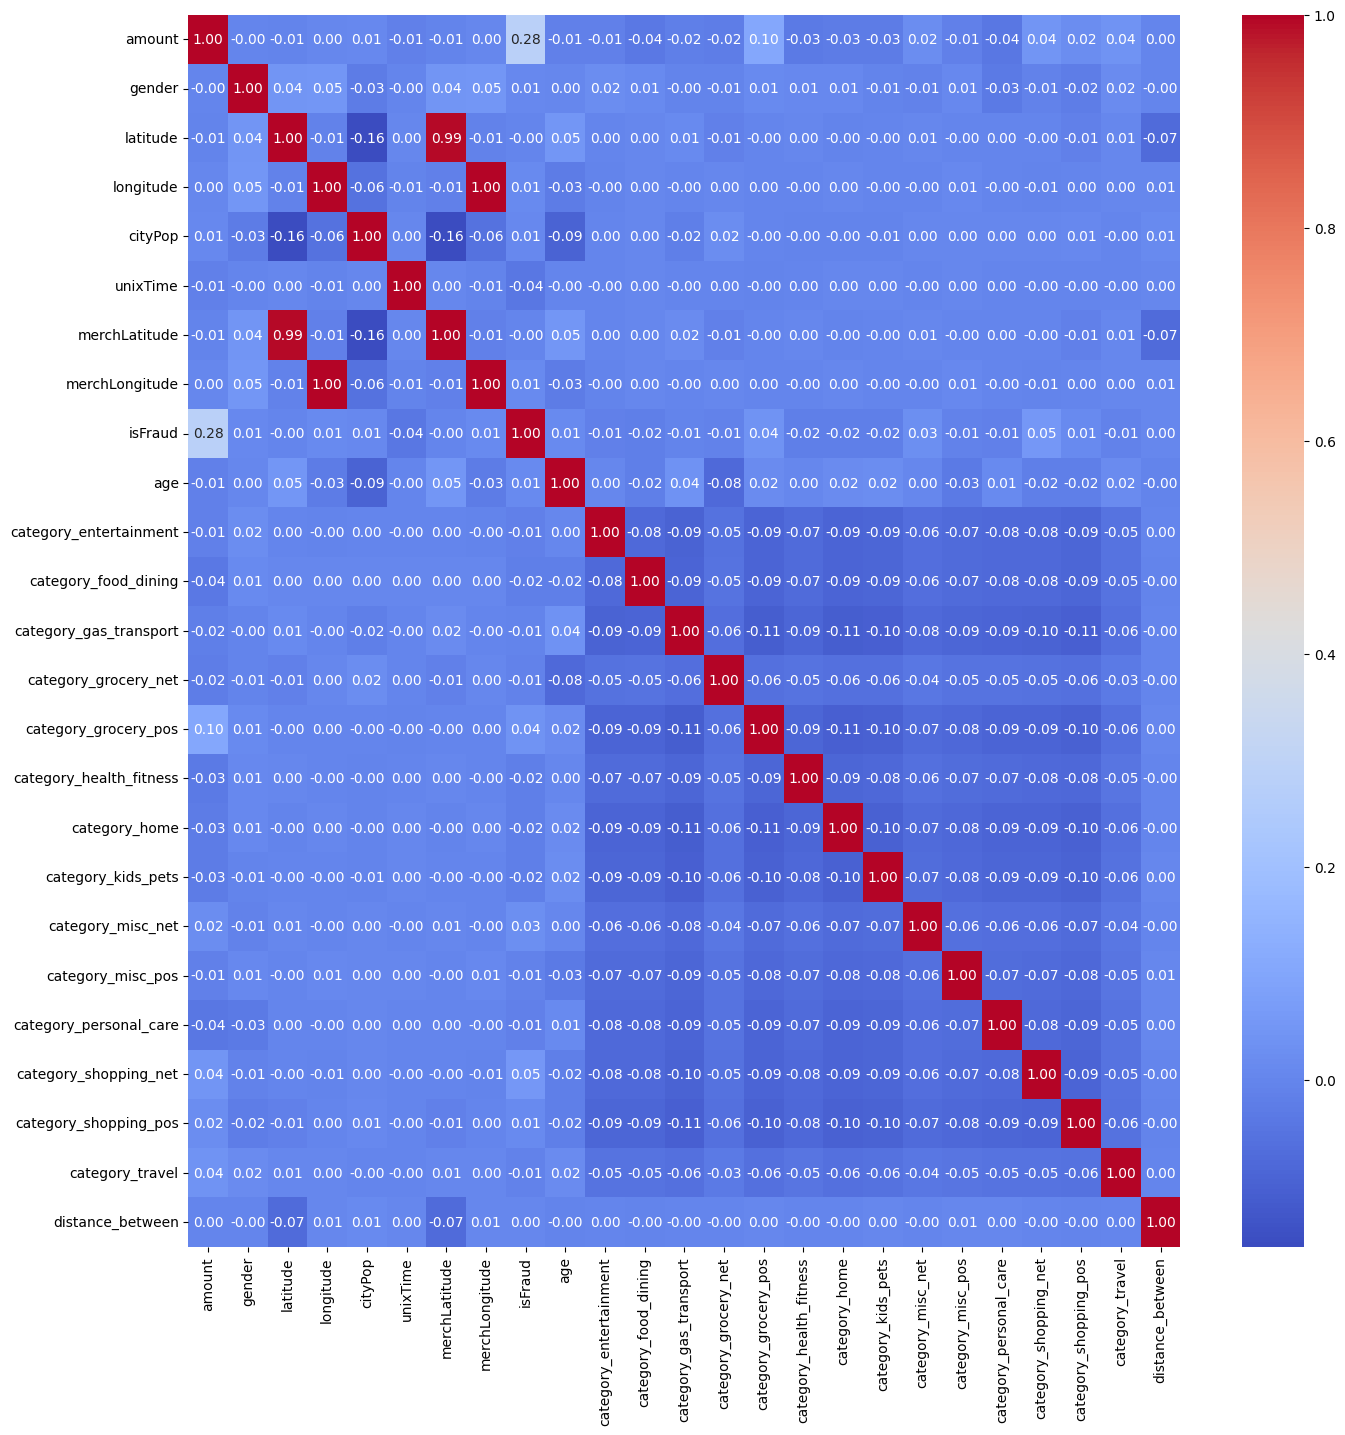

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set the matplotlib figure
plt.figure(figsize=(16, 16))

# Create a heatmap to visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.show()


In [14]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Fit the RandomForestClassifier
sel = RandomForestClassifier(n_estimators=100)
sel.fit(X_under_train, y_under_train)

# Get the importances of features
importances = sel.feature_importances_

# Set a threshold for feature selection: for instance, the median of importances
threshold_value = np.median(importances)

# Create the SelectFromModel object with your defined threshold
selection = SelectFromModel(sel, threshold=threshold_value)
selection.fit(X_under_train, y_under_train)

# Get the boolean mask of the selected features
selected_features_mask = selection.get_support()

# Get the names of the selected features
selected_features = X_under_train.columns[selected_features_mask]

# Count and print the selected features
print(f"Number of selected features: {selected_features.shape[0]}")
print(selected_features)


Number of selected features: 12
Index(['amount', 'latitude', 'longitude', 'cityPop', 'unixTime',
       'merchLatitude', 'merchLongitude', 'age', 'category_gas_transport',
       'category_grocery_pos', 'category_shopping_net', 'distance_between'],
      dtype='object')


# 7. Dropping Columns

In [15]:

# List of columns to keep
columns_to_keep = ['amount', 'cityPop', 'unixTime', 'merchLatitude', 'merchLongitude',
       'age', 'category_gas_transport', 'category_grocery_pos',
       'category_shopping_net', 'distance_between']

# Create a new DataFrame with only the specified columns
X_under_train = X_under_train[columns_to_keep]
X_under_test = X_under_test[columns_to_keep]

In [16]:
X_under_train.to_csv("./data/X_train.csv")
y_under_train.to_csv("./data/y_train.csv")
X_under_test.to_csv("./data/X_test.csv")
y_under_test.to_csv("./data/y_test.csv")

## Applying to the whole dataset

In [17]:
columns_to_keep = ['amount', 'cityPop', 'unixTime', 'merchLatitude', 'merchLongitude',
       'age', 'category_gas_transport', 'category_grocery_pos',
       'category_shopping_net', 'distance_between', 'isFraud']

df = df[columns_to_keep]
df.to_csv("./data/data.csv")

df.head()

,amount,cityPop,unixTime,merchLatitude,merchLongitude,age,category_gas_transport,category_grocery_pos,category_shopping_net,distance_between,isFraud
0,0.000032,0.000041,0.000000,0.440700,0.772111,0.7375,False,False,False,0.572049,0
1,0.000021,0.000005,0.000000,0.390349,0.842510,0.9750,False,False,True,0.298690,0
2,0.000178,0.000002,0.000002,0.420541,0.448314,0.6250,False,False,False,0.823143,0
3,0.000074,0.000019,0.000002,0.509176,0.725492,0.5000,False,False,False,0.507048,0
4,0.001002,0.000012,0.000008,0.423723,0.885317,0.4875,False,True,False,0.358400,0


In [18]:
df.shape

(181822, 11)